In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from transformers import DeiTForImageClassification, DeiTConfig, AutoModelForImageClassification
import numpy as np

2025-05-06 23:09:02.581920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 23:09:02.660579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Define image transformations (preprocessing for CNN)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pretrained models
])

In [5]:
horizontal_flip_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
vertical_flip_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
random_rotatation_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomRotation(degrees=25), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [6]:
# Set up dataset and dataloaders
# Assuming images are organized in folders: 'root_folder/class1/', 'root_folder/class2/', etc.
data_dir = './maps_git/'  # Path to your image folder
train_data_1 = datasets.ImageFolder(root=data_dir, transform=horizontal_flip_transform)
train_data_2 = datasets.ImageFolder(root=data_dir, transform=vertical_flip_transform)
train_data_3 = datasets.ImageFolder(root=data_dir, transform=random_rotatation_transform)
train_data_4 = datasets.ImageFolder(root=data_dir, transform=transform)
augmented_dataset = ConcatDataset([train_data_1, train_data_2, train_data_3, train_data_4])
train_size = int(0.7 * len(augmented_dataset))
val_size = int(0.2 * len(augmented_dataset))
test_size = len(augmented_dataset) - (train_size + val_size)
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(augmented_dataset, [train_size, val_size, test_size], generator=generator1)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [10]:
dataset = datasets.ImageFolder(root=data_dir, transform=None)

In [11]:
dataset.classes

['AA', 'AI', 'IA', 'II']

In [ ]:
# Load DeiT Pre-trained Model
model = torch.hub.load('facebookresearch/deit:main',
                           'deit_base_distilled_patch16_224', pretrained=True)

In [ ]:
num_classes = 4  # Set your number of classes

# Replace classification head
model.head = nn.Linear(model.head.in_features, num_classes)

# Replace distillation head
model.head_dist = nn.Linear(model.head_dist.in_features, num_classes)
model.to(device)

In [ ]:
# Freeze Layers 0 to 8
for layer_idx, layer in enumerate(model.blocks):
    if layer_idx < 9:  # Freeze layers 1 to 11 (index 0 to 10)
        for param in layer.parameters():
            param.requires_grad = False
    else:
        # Ensure layers 9, 10, 11 remains trainable
        for param in layer.parameters():
            param.requires_grad = True

# Confirm that only layer > 9's parameters are trainable
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

# Update Optimizer: Only trainable parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [ ]:
%%time
NUM_EPOCHS = 20

best_val_loss = float('inf')
patience = 5
counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        cls_logits, dist_logits = model(inputs)
        logits = (cls_logits + dist_logits) / 2
        loss = criterion(logits, labels)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.2f}%")

    # Validation Phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Single output during validation
        
            # Handle both cases:
            if isinstance(outputs, tuple):  # Training-style dual outputs
                cls_logits, dist_logits = outputs
                logits = (cls_logits + dist_logits) / 2
            else:  # Single output during validation
                logits = outputs
                
            loss = criterion(logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(100 * correct_val / total_val)
    #scheduler.step(avg_val_loss)
    
    print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "Deit_faceRes_base_distilled.pth")
        print('The best model was saved.')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

In [ ]:
# Plot Training and Validation Loss/Accuracy
epochs = range(1, 16 + 1)

plt.figure(figsize=(12, 6))
# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

print("Fine-tuning complete!")

In [14]:
#To load the saved weights into the model architecture:
model.load_state_dict(torch.load("Deit_faceRes_base_distilled.pth")) 

/tmp/ipykernel_5336/1218333698.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Deit_faceRes_base_distilled.pth"))


<All keys matched successfully>

In [15]:
def test_model(model, loader):
    model.eval()
    acc = 0.
    y_test, y_prediction = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)  # Returns an ImageClassifierOutput object
            logits = outputs  # Extract logits

            # Get predictions
            pred = logits.argmax(dim=1)
            acc += (pred == labels).sum().item()

            y_test.extend(labels.cpu().numpy())
            y_prediction.extend(pred.cpu().numpy())

    size = len(loader.dataset)
    acc = 100 * acc / size
    print(f'Test accuracy on {size} test samples is {acc:.2f}%')

    return y_test, y_prediction

In [16]:
class_names = {0: 'AA', 1: 'AI', 2: 'IA', 3: 'II'}
kept_classes = [0, 1, 2, 3]

In [17]:
def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()
    # Put number of each cell in plot
    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

Test accuracy on 350 test samples is 78.57%


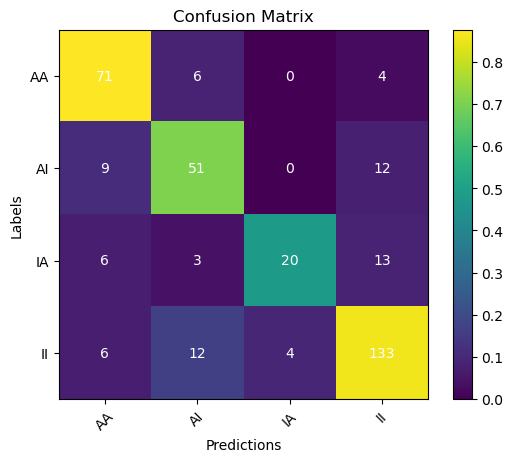

In [18]:
# Test the model
y_test, y_pred = test_model(model, test_loader)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, kept_classes)

In [19]:
print(classification_report(y_test, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

          AA       0.77      0.88      0.82        81
          AI       0.71      0.71      0.71        72
          IA       0.83      0.48      0.61        42
          II       0.82      0.86      0.84       155

    accuracy                           0.79       350
   macro avg       0.78      0.73      0.74       350
weighted avg       0.79      0.79      0.78       350

